In [1]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score 
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = '/content/drive/MyDrive/model-1'
DATASET_PATH = '/content/drive/MyDrive/Image-Classification-Dataset'

class_names = ["Leopard" ,"Tiger" ,"Horse" ,"Lion" ,"Zebra"]


test_dir = os.path.join(DATASET_PATH ,"test")

Mounted at /content/drive


In [3]:
def decode_image_and_label(filename):
  image = tf.io.decode_image(tf.io.read_file(filename) ,expand_animations = False)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  label = tf.cast(label == class_names, tf.int8)
  return image, label

@tf.function
def preprocess_test(image, label):
  image = tf.image.resize(image, (224, 224))
  image = image / 255.0
  return (image, label)

In [4]:
IMAGE_SIZE = 224
BATCH = 64
AUTO = tf.data.AUTOTUNE

test_ds = tf.data.Dataset.list_files(str(test_dir+'/*/*'))

pipeline_test = (
    test_ds.map(decode_image_and_label).map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH)
    .prefetch(AUTO)
)


In [5]:
model = tf.keras.models.load_model(MODEL_PATH)

In [ ]:
model.summary()

In [7]:
def get_labels_and_predictions(test_dataset) :
    class_names = ["Leopard" ,"Tiger" ,"Horse" ,"Lion" ,"Zebra"]
    labels = []
    preds  = []
    for item in test_dataset.take(-1) :
      image_batch = item[0]
      label_batch = item[1]
      y_pred= model.predict(image_batch)
      for y in np.array(y_pred) :
          preds.append(y.argmax())

      for lbl in np.array(label_batch) :
          labels.append(lbl.argmax())

    return np.array(labels) ,np.array(preds)

In [8]:
labels  ,preds = get_labels_and_predictions(pipeline_test)
conf_mat = confusion_matrix(labels, preds)
accuracy_test = accuracy_score(labels, preds)

In [9]:
def get_precision(conf ,class_):
  return conf[class_, class_] / conf_mat.sum(axis=0)[class_]
def get_recall(conf ,class_):
  return conf[class_, class_] / conf_mat.sum(axis=1)[class_]

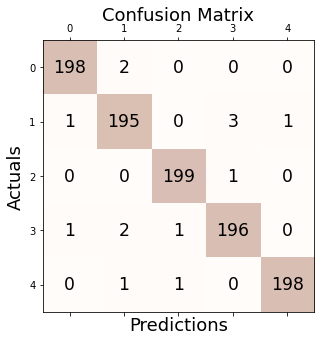

In [10]:
def plot_confusion_matrix():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

plot_confusion_matrix()

In [11]:
print("Test Accuracy:{:.2f}%".format(accuracy_test*100))
print( "-" * 30 )
print("Confusion Matrix :\n{}".format(conf_mat))
print( "-" * 30 )
for i,class_ in enumerate(class_names):
    print("Class {}:\n\tPrecision : {:.2f}\n\tRecall: {:.2f}"
    .format(class_ ,get_precision(conf_mat,i),get_recall(conf_mat,i)))

Test Accuracy:98.60%
------------------------------
Confusion Matrix :
[[198   2   0   0   0]
 [  1 195   0   3   1]
 [  0   0 199   1   0]
 [  1   2   1 196   0]
 [  0   1   1   0 198]]
------------------------------
Class Leopard:
	Precision : 0.99
	Recall: 0.99
Class Tiger:
	Precision : 0.97
	Recall: 0.97
Class Horse:
	Precision : 0.99
	Recall: 0.99
Class Lion:
	Precision : 0.98
	Recall: 0.98
Class Zebra:
	Precision : 0.99
	Recall: 0.99
